In [2]:
#import packages

import pandas as pd
import twint
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from string import punctuation
import re
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import textblob
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
init_notebook_mode(connected=True)

In [1]:
conda install -c plotly plotly=4.6.0

Solving environment: ...working... 
  - anaconda/win-64::openssl-1.1.1d-he774522_2
  - defaults/win-64::openssl-1.1.1d-he774522_2done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


## Get Tweet Data

Before we start to analyize the data, we need a collection of tweets. So let's use Twint to scrape Twitter for all tweets that mention Billie Eilish. She will be our pilot subject that we'll use to gather data on so that we can start getting insights on her audience. Let's gather all tweets from the last year with 'billie eilish' as our search keyword.

In [2]:
#need a function to scrape twitter data


# c = twint.Config()


# c.Format = "ID {id} | Tweet {tweet}"
# c.Search = 'billie eilish'
# c.Lang = 'en'
# c.Pandas_clean = True
# c.Since = '2019-03-31'
# c.Store_csv = True
# c.Output = 'tweets.csv'
# twint.run.Search(c)



## Data Cleaning

In [40]:
#lets read in the dataframe

df = pd.read_csv('tweets.csv')


In [41]:
#how many tweets did we get?

df.shape

(14556, 34)

In [42]:
#let's see if there's anything missing from our dataframe and see if we can get rid of anything

df.isna().sum()

id                     0
conversation_id        0
created_at             0
date                   0
time                   0
timezone               0
user_id                0
username               0
name                   0
place              14554
tweet                  0
mentions               0
urls                   0
photos                 0
replies_count          0
retweets_count         0
likes_count            0
hashtags               0
cashtags               0
link                   0
retweet                0
quote_url          13731
video                  0
near               14556
geo                14556
source             14556
user_rt_id         14556
user_rt            14556
retweet_id         14556
reply_to               0
retweet_date       14556
translate          14556
trans_src          14556
trans_dest         14556
dtype: int64

In [43]:
df.drop(['place', 'quote_url', 'near', 'geo', 'source', 'user_rt_id', 'user_rt', 'retweet_id', 'retweet_date', 'translate', 
        'trans_src', 'trans_dest'], inplace=True, axis=1)

### Preprocess Raw Text



In [44]:
df.tweet.head(10)

0    #158: Rez Fail- when mercy tries to Rez and sh...
1                THIS! Has made my day! Gracias!!! 🥔🍠🍟
2                     Billie Eilish & Khalid-lovely 🎧👌
3    Do you guys an artist that you listen to and n...
4                       What the fuck is Billie Eilish
5       YASSSSSSSSSSSSSSSSSS\n\nGOOD JOB GURL @DojaCat
6    bro billie eilish gotta eat ranch you're entitled
7                           @billieeilish marry me PLS
8                       Also how did you do that?! Lol
9    fav artists? like musicians gfdfhgh — paramore...
Name: tweet, dtype: object

#### Remove Handles

In [45]:
#removing user handles from tweets
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt 

df['tidy_tweet'] = np.vectorize(remove_pattern)(df['tweet'], "@[\w]*")


#### Remove URLs

In [46]:
df['tidy_tweet'] = np.vectorize(remove_pattern)(df['tidy_tweet'], "http[\S]*")
df['tidy_tweet'] = np.vectorize(remove_pattern)(df['tidy_tweet'], "pic.twitter.com/[\w]*")

#### Remove Punctuations, special characters, numbers

In [47]:
# remove special characters, numbers, punctuations
df['tidy_tweet'] = df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

#### Tokenize Tweets

In [48]:
#tokenize tweets

def tokenization(text):
    text = re.split('\W+', text)
    return text

df['tokenized_tweet'] = df['tidy_tweet'].apply(lambda x: tokenization(x.lower()))
df['tokenized_tweet'].head(10)

0    [, rez, fail, when, mercy, tries, to, rez, and...
1                [this, has, made, my, day, gracias, ]
2                   [billie, eilish, khalid, lovely, ]
3    [do, you, guys, an, artist, that, you, listen,...
4                [what, the, fuck, is, billie, eilish]
5            [yassssssssssssssssss, good, job, gurl, ]
6    [bro, billie, eilish, gotta, eat, ranch, you, ...
7                                   [, marry, me, pls]
8                 [also, how, did, you, do, that, lol]
9    [fav, artists, like, musicians, gfdfhgh, param...
Name: tokenized_tweet, dtype: object

#### Remove short Words

In [49]:
# removing short words

df['tidy_tweet'] =df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

#### Lemmatize Tweets

In [50]:
#create another column where the words are lemmatized

lemmatizer = WordNetLemmatizer()

In [51]:
df['lemmatized_tweets'] = df['tidy_tweet'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word.lower()) for word in x.split()]))

#### Remove Stopwords

In [52]:
stop_words = list(set(stopwords.words('english')))

#adding stopwords that include search term and song titles
new_stopwords = ['billie', 'eilish', 'billieeilish', 'all', 'the', 'good', 'girls', 'go', 'to', 'hell', 'everything', 'i', 'wanted', 'bad', 'guy', 'lovely', 
                 'ocean', 'eyes', 'when', 'over', 'no', 'time', 'to', 'die', 'bellyache', 'xanny', 'wish', 'you', 'were' 'gay']
stop_words.extend(new_stopwords)

In [53]:
non_stopword_tweets = []
for i in df['lemmatized_tweets']:
    
    word_tokens = word_tokenize(i) 
    non_stopword_tweets.append(' '.join([word for word in word_tokens if word not in stop_words]))

    
df['lemmatized_tweets'] = non_stopword_tweets

#### Sentiment Analysis

In [54]:
analyser = SentimentIntensityAnalyzer()

In [55]:
def get_tweet_sentiment(tweet):
    polarity_scores = analyser.polarity_scores(tweet)
    return polarity_scores['compound']

get_tweet_sentiment(df['tweet'][0])

-0.8225

In [56]:
df['tweet_sentiment'] = df['tweet'].apply(lambda x: get_tweet_sentiment(x))

In [57]:
df['sentiment_polarity'] = df['tweet_sentiment'].apply(lambda x: 'positive' if x > 0 else ('neutral' if x == 0 else 'negative'))


In [58]:
sentiment_countdf = df.groupby('sentiment_polarity')['id'].count().reset_index()
sentiment_countdf


,sentiment_polarity,id
0,negative,2868
1,neutral,4612
2,positive,7076


Text(0, 0.5, '# of Tweets')

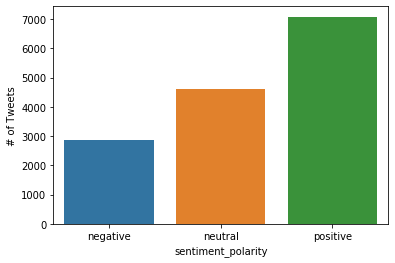

In [59]:
sns.barplot(data=sentiment_countdf, x='sentiment_polarity', y='id')
plt.ylabel('# of Tweets')

In [60]:
#create dataframes of positive and negative tweets
positive_tweets_df = df.loc[df['sentiment_polarity'] == 'positive']
negative_tweets_df = df.loc[df['sentiment_polarity'] == 'negative']

In [61]:
popular_tweets_df = df.loc[df['retweets_count'] > 50]
unpopular_tweets_df = df.loc[df['retweets_count'] < 50]

In [62]:
df.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'tweet', 'mentions', 'urls', 'photos',
       'replies_count', 'retweets_count', 'likes_count', 'hashtags',
       'cashtags', 'link', 'retweet', 'video', 'reply_to', 'tidy_tweet',
       'tokenized_tweet', 'lemmatized_tweets', 'tweet_sentiment',
       'sentiment_polarity'],
      dtype='object')

In [68]:
df.dropna('lemmatized_tweets', axis=0)

TypeError: dropna() got multiple values for argument 'axis'

### Save Cleaned data

In [64]:
df.to_csv('clean_billie_tweets.csv')

## EDA

### Open clean dataframe

In [65]:
clean_df = pd.read_csv('clean_billie_tweets.csv', index_col=0)


In [29]:
#let's explore the distribution of tweets by date

tweets_by_date = clean_df.groupby('date')['tweet'].count().reset_index()

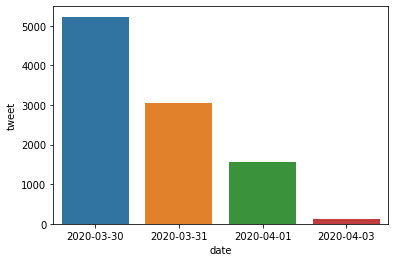

In [30]:
sns.barplot(data=tweets_by_date, x='date', y='tweet')

### Frequent Words - WordClouds

In [31]:
#let's visualize the most frequent words from the entire dataset

all_words = ' '.join([text for text in clean_df['lemmatized_tweets'] if type(text) != float])


In [32]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)


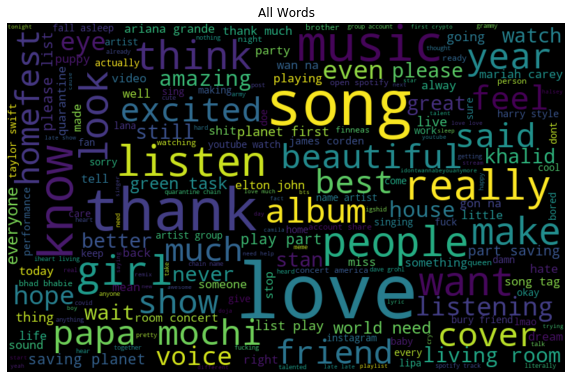

In [33]:
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('All Words')
plt.show()

In [34]:
#lets look out wordclouds for each date

march30_df = clean_df[clean_df['date'] == '2020-03-30']
march31_df = clean_df[clean_df['date'] == '2020-03-31']
april1_df = clean_df[clean_df['date'] == '2020-04-01']

m30_words = ' '.join([text for text in march30_df['lemmatized_tweets'] if type(text) != float])
m30_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(m30_words)


m31_words = ' '.join([text for text in march31_df['lemmatized_tweets'] if type(text) != float])
m31_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(m31_words)


a1_words = ' '.join([text for text in april1_df['lemmatized_tweets'] if type(text) != float])
a1_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(a1_words)


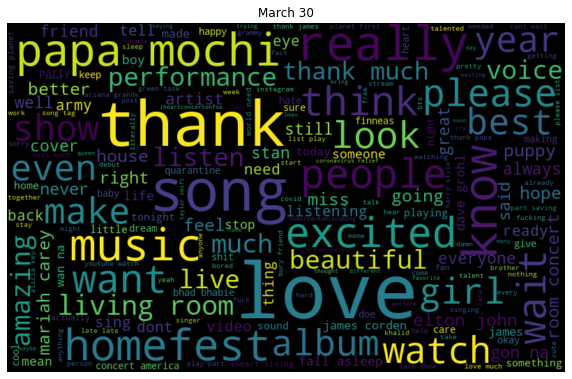

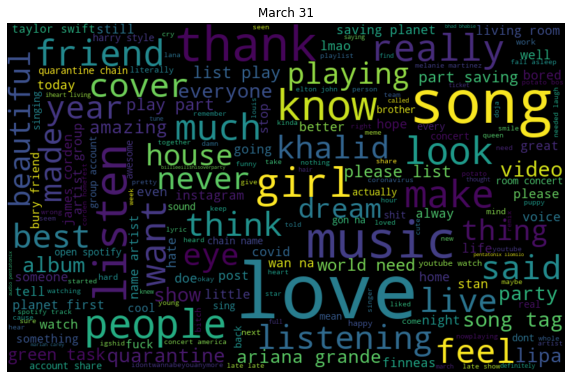

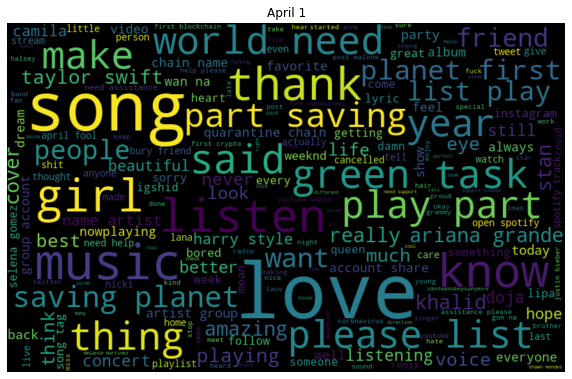

In [35]:


plt.figure(figsize=(10, 7))
plt.imshow(m30_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('March 30')
plt.show()

plt.figure(figsize=(10, 7))
plt.imshow(m31_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('March 31')
plt.show()

plt.figure(figsize=(10, 7))
plt.imshow(a1_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('April 1')
plt.show()

#### Most Frequent Words

In [69]:


# all_word_list = word_tokenize(all_words)
clean_df['lemmatized_tweets'].dropna(inplace=True)

In [37]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(clean_df['lemmatized_tweets'], 50)
for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')

like 1180
love 1142
song 805
thank 577
please 413
music 407
much 375
know 330
need 322
really 317
concert 292
watch 290
http 283
homefest 277
artist 274
would 272
james 264
girl 262
play 256
people 255
listen 254
look 243
show 241
friend 240
wait 240
make 233
want 230
first 223
world 219
think 215
year 213
na 209
home 196
best 195
video 192
mochi 192
youtube 188
said 184
live 184
excited 183
amazing 182
thing 179
feel 175
papa 174
voice 173
beautiful 173
list 173
album 170
thanks 168
cover 166


AttributeError: 'Series' object has no attribute 'iplot'

### Wordclouds for positive/negative tweets

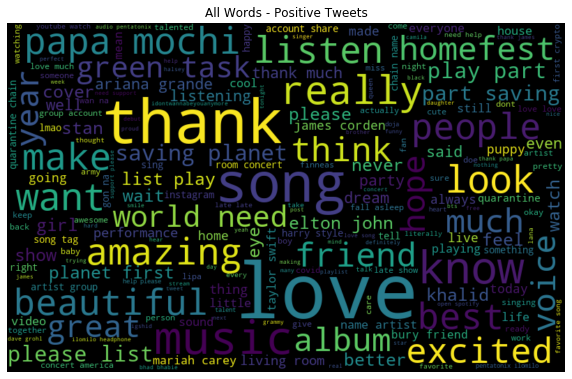

In [38]:
#let's visualize the most frequent words from the entire dataset

all_words_positive = ' '.join([text for text in positive_tweets_df['lemmatized_tweets'] if type(text) != float])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_positive)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('All Words - Positive Tweets')
plt.show()

In [41]:
# common_words = get_top_n_words(positive_tweets_df['lemmatized_tweets'], 50)
# for word, freq in common_words:
#     print(word, freq)
# df1 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
# df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
# kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')

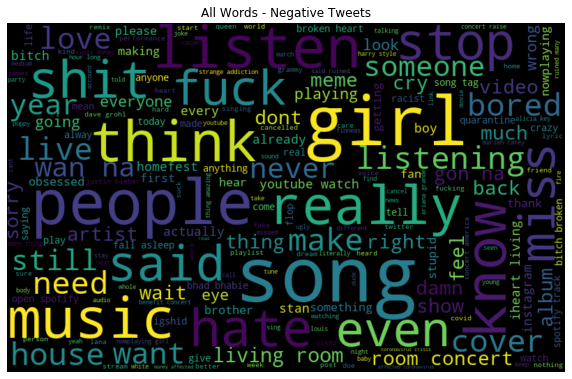

In [40]:
#wordcloud for negative tweets

all_words_negative = ' '.join([text for text in negative_tweets_df['lemmatized_tweets'] if type(text) != float])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_negative)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('All Words - Negative Tweets')
plt.show()

In [181]:
# common_words = get_top_n_words(negative_tweets_df['lemmatized_tweets'], 50)
# for word, freq in common_words:
#     print(word, freq)
# df1 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
# df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
# kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')

### Wordclouds for Popular/Unpopular Tweets

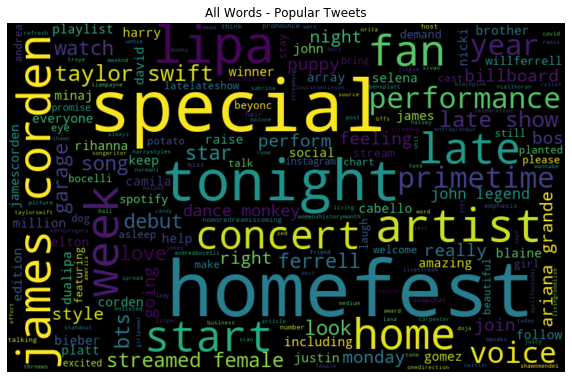

In [42]:
#wordcloud for popular retweets (over 50)

all_words_popular = ' '.join([text for text in popular_tweets_df['lemmatized_tweets'] if type(text) != float])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_popular)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('All Words - Popular Tweets')
plt.show()

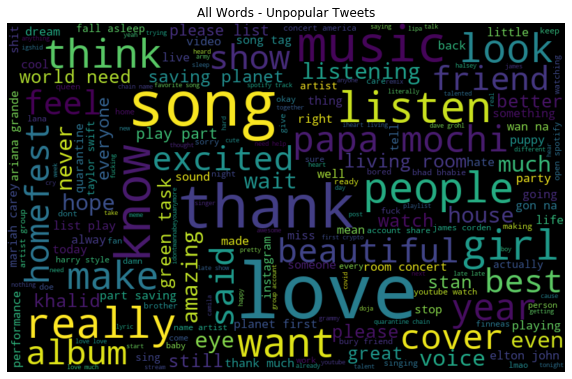

In [186]:
#wordcloud for unpopular retweets (less than 50)

all_words_unpopular = ' '.join([text for text in unpopular_tweets_df['lemmatized_tweets'] if type(text) != float])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_unpopular)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('All Words - Unpopular Tweets')
plt.show()

### distribution of top unigrams after  stop words

Text(0.5, 1.0, 'Top Words from Popular Tweets')

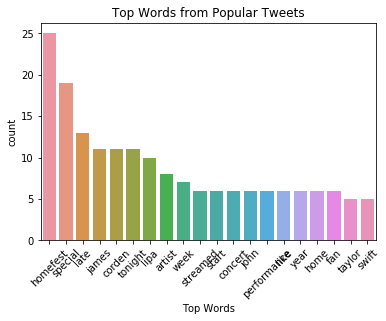

In [72]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(popular_tweets_df['lemmatized_tweets'], 20)

# for word, freq in common_words:
#     print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['Top Words' , 'count'])
sns.barplot(data=df2, x='Top Words', y='count')
plt.xticks(rotation=45)
plt.title('Top Words from Popular Tweets')
# df2.groupby('lemmatized_tweets').sum()['count'].sort_values(ascending=False).iplot(
#     kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')


Text(0.5, 1.0, 'Top Words from All Tweets')

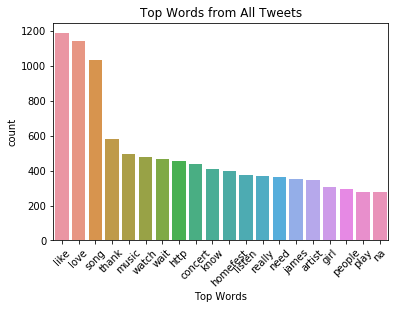

In [75]:
common_words = get_top_n_words(clean_df['lemmatized_tweets'], 20)

# for word, freq in common_words:
#     print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['Top Words' , 'count'])
sns.barplot(data=df2, x='Top Words', y='count')
plt.xticks(rotation=45)
plt.title('Top Words from All Tweets')

### The distribution of top bigrams after removing stop words


Text(0.5, 1.0, 'Top Bigrams from Popular Tweets')

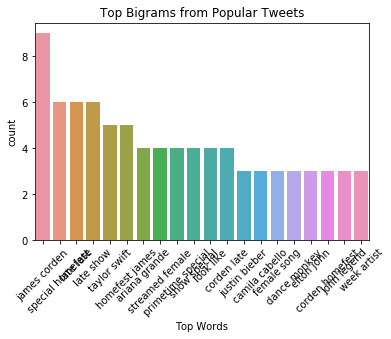

In [73]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(popular_tweets_df['lemmatized_tweets'], 20)
# for word, freq in common_words:
#     print(word, freq)
df3 = pd.DataFrame(common_words, columns = ['Top Words' , 'count'])

sns.barplot(data=df3, x='Top Words', y='count')
plt.xticks(rotation=45)
plt.title('Top Bigrams from Popular Tweets')



Text(0.5, 1.0, 'Top Bigrams from All Tweets')

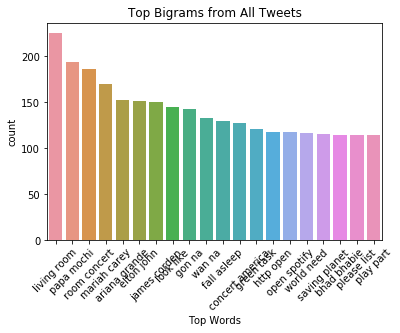

In [74]:
common_words = get_top_n_bigram(clean_df['lemmatized_tweets'], 20)
# for word, freq in common_words:
#     print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['Top Words' , 'count'])

sns.barplot(data=df4, x='Top Words', y='count')
plt.xticks(rotation=45)
plt.title('Top Bigrams from All Tweets')


### TF-IDF
Let's calculate the importance of each word using TF-IDF scores. This will help us decide if there are other words we should be adding to our stopword list. Using non lemmatized words.

In [369]:
#drop rows with nan values in tweets
clean_df.dropna(axis=0, subset=['lemmatized_tweets'], inplace=True)

#### Vectorize Words

In [370]:
#create function to vectorize song

def count_vectorize(tweet, vocab=None):
    tokenized_tweet = word_tokenize(tweet)
    if vocab:
        unique_words = vocab
    else:
        unique_words = list(set(tokenized_tweet))
    
    tweet_dict = {i:0 for i in unique_words}
    
    for word in tokenized_tweet:
        tweet_dict[word] += 1
    
    return tweet_dict

In [371]:
BoW = count_vectorize(clean_df['clean_tweets'][0])

#### Term Frequency

In [372]:
#Term Frequency

#create term frequency function
def term_frequency(BoW_dict):
    total_word_count = sum(BoW_dict.values())
    
    for ind, val in BoW_dict.items():
        BoW_dict[ind] = val/ total_word_count
    
    return BoW_dict

BoW_dict = term_frequency(BoW)

#### Create List of Dictionaries

In [373]:
#create a list of dictionaries
def create_list_of_BoW(tweets):

    list_of_dictionaries = []

    for tweet in tweets:
        BoW = count_vectorize(tweet)

        list_of_dictionaries.append(BoW)
    return list_of_dictionaries

list_of_dictionaries = create_list_of_BoW(clean_df['lemmatized_tweets'])


#### Inverse Document Frequency

In [374]:
#Inverse Document Frequency
def inverse_document_frequency(list_of_dicts):
    vocab_set = set()
    # Iterate through list of dfs and add index to vocab_set
    for d in list_of_dicts:
        for word in d.keys():
            vocab_set.add(word)
    
    # Once vocab set is complete, create an empty dictionary with a key for each word and value of 0.
    full_vocab_dict = {i:0 for i in vocab_set}
    
    # Loop through each word in full_vocab_dict
    for word, val in full_vocab_dict.items():
        docs = 0
        
        # Loop through list of dicts.  Each time a dictionary contains the word, increment docs by 1
        for d in list_of_dicts:
            if word in d:
                docs += 1
        
        # Now that we know denominator for equation, compute and set IDF value for word
        
        full_vocab_dict[word] = np.log((len(list_of_dicts)/ float(docs)))
    
    return full_vocab_dict

In [375]:
tf_idf_dict = inverse_document_frequency(list_of_dictionaries)

In [376]:
tf_idf_dict

{'state': 7.269616749608169,
 'fobo': 9.572201842602215,
 'aloud': 8.87905466204227,
 'focso': 9.572201842602215,
 'zero': 7.174306569803845,
 'blockchain': 6.075694281135735,
 'homegirl': 9.572201842602215,
 'considered': 9.572201842602215,
 'paak': 8.185907481482324,
 'reach': 7.962763930168115,
 'involving': 8.473589553934106,
 'hxqnte': 9.572201842602215,
 'awhhh': 9.572201842602215,
 'ittttt': 9.572201842602215,
 'suffered': 9.572201842602215,
 'ixtdyj': 9.572201842602215,
 'populair': 9.572201842602215,
 'dizzy': 8.87905466204227,
 'losowo': 8.87905466204227,
 'fireweed': 9.572201842602215,
 'heeeey': 9.572201842602215,
 'center': 8.473589553934106,
 'oyqnwiw': 9.572201842602215,
 'setthevcr': 9.572201842602215,
 'revealed': 9.572201842602215,
 'musicnews': 7.269616749608169,
 'totoro': 9.572201842602215,
 'northeast': 9.572201842602215,
 'provides': 9.572201842602215,
 'brooke': 9.572201842602215,
 'guitar': 7.374977265265996,
 'carnegie': 9.572201842602215,
 'crowded': 9.572201

In [ ]:
tf_idf_dict.

In [278]:

stop_word_dict = []
for k,v in (tf_idf_dict.items()):
    if tf_idf_dict[k] < 6:
        stop_word_dict.append((k,v))

print(stop_word_dict)
        

[('meet', 5.989100644178637), ('iheart', 4.535666980221118), ('famous', 5.743978186145652), ('backstreet', 5.9350334229083614), ('saving', 4.744305845332446), ('still', 4.595885840214173), ('thought', 5.141802783791433), ('getting', 5.309939705593432), ('felt', 5.478275020412647), ('probably', 5.834949964351378), ('dear', 5.909057936505101), ('kpop', 5.811419466941184), ('band', 5.529568314800197), ('seen', 5.445485197589655), ('want', 4.130201872112953), ('watch', 3.4545223845933988), ('spotify', 4.325595510474261), ('definitely', 5.961701669990522), ('march', 5.7659570928644275), ('book', 5.9350334229083614), ('pentatonix', 5.701418571726856), ('streaming', 5.640793949910421), ('doja', 5.040020089481491), ('stupid', 5.660596577206601), ('lorde', 5.909057936505101), ('person', 5.338513078037487), ('true', 5.811419466941184), ('ticket', 5.701418571726856), ('chain', 5.35311187745864), ('first', 4.07136137209002), ('troye', 5.961701669990522), ('alicia', 5.309939705593432), ('btsonhomef

In [54]:
#find min and max TF-IDF value in corpus

key_max = max(tf_idf_dict.keys(), key=(lambda k: tf_idf_dict[k]))
key_min = min(tf_idf_dict.keys(), key=(lambda k: tf_idf_dict[k]))

print('Maximum Value: ',tf_idf_dict[key_max])
print('Minimum Value: ',tf_idf_dict[key_min])

Maximum Value:  9.58293787645873
Minimum Value:  0.40843195749176353
